This file script tests if the link between occupancy (measured by light) and energy consumption. The script uses local law 84 data for energy consumption by building. Pluto data sets have the number of units. 

In [22]:
import os
import json
import pandas as pd
from pandas.tools.plotting import scatter_matrix
import geopandas as gp
import pylab as pl
import statsmodels.api as sm
import statsmodels.formula.api as smf
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [23]:
#import energy data from local law 84. LL84 file is saved in the same 
#directory as this code
nrg = gp.GeoDataFrame.from_csv('Energy_and_Water_Data_Disclosure_for_Local_Law_84__2013_.csv')
#print columns to review data we are working with
print nrg.columns #note data type is object

Index([u'NYC Borough, Block, and Lot (BBL)', u'Co-reported BBL Status',
       u'BBLs Co-reported',
       u'Reported NYC Building Identificaiton Numbers (BINs)',
       u'Street Number', u'Street Name', u'Borough', u'Zip Code',
       u'DOF Benchmarking Submission Status', u'Site EUI(kBtu/ft2)',
       u'Weather Normalized Site EUI(kBtu/ft2)', u'Source EUI(kBtu/ft2)',
       u'Weather Normalized Source EUI(kBtu/ft2)',
       u'Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)',
       u'Automatic Water Benchmarking Eligible', u'Reported Water Method',
       u'ENERGY STAR Score', u'Total GHG Emissions(MtCO2e)',
       u'Direct GHG Emissions(MtCO2e)', u'Indirect GHG Emissions(MtCO2e)',
       u'Reported Property Floor Area (Building(s)) (ft²)',
       u'DOF Property Floor Area (Buildngs and Parking)(ft2)',
       u'Primary Property Type - Self Selected', u'DOF Number of Buildings'],
      dtype='object')


In [24]:
#import pluto data set to get the number of units (Note this is for 
#Manhattan Only). Pluto file is saved in the same directory as this code
bsize = gp.GeoDataFrame.from_file('Manhattan/MNMapPLUTO.shp')
#print columns to review the data we are working with
print bsize.columns #note data type is object

Index([    u'APPBBL',    u'APPDate',    u'Address', u'AllZoning1',
       u'AllZoning2', u'AreaSource', u'AssessLand',  u'AssessTot',
              u'BBL',   u'BldgArea',  u'BldgClass',  u'BldgDepth',
        u'BldgFront',      u'Block',   u'BoroCode',    u'Borough',
         u'BsmtCode',  u'BuiltCode',   u'BuiltFAR',     u'CB2010',
               u'CD',     u'CT2010',    u'ComArea',    u'CommFAR',
          u'CondoNo',    u'Council',  u'EDesigNum',  u'Easements',
       u'ExemptLand',  u'ExemptTot',        u'Ext',   u'FacilFAR',
       u'FactryArea',   u'FireComp', u'GarageArea', u'HealthArea',
         u'HistDist', u'IrrLotCode',    u'LandUse',   u'Landmark',
              u'Lot',    u'LotArea',   u'LotDepth',   u'LotFront',
          u'LotType',  u'LtdHeight', u'MAPPLUTO_F',   u'NumBldgs',
        u'NumFloors', u'OfficeArea',  u'OtherArea',   u'Overlay1',
         u'Overlay2',  u'OwnerName',  u'OwnerType', u'PLUTOMapID',
       u'PolicePrct',   u'ProxCode',    u'ResArea',   u'ResidF

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1338d5650>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x10df33910>]], dtype=object)

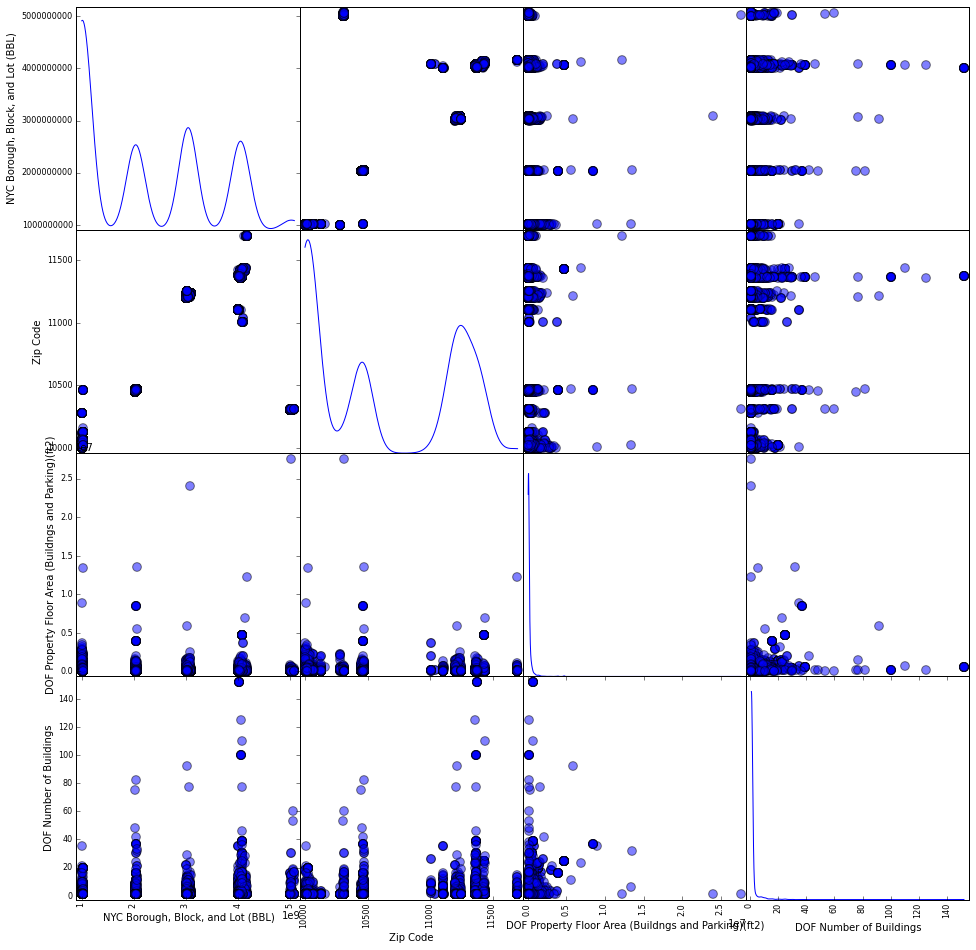

In [25]:
#Plot a Scatter Matrix with diagonals as density functions for the energy data
#from pandas.tools.plotting import scatter_matrix
scatter_matrix (nrg, s = 300, figsize = (16, 16), diagonal = 'kde')


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12dc5bed0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1206fcc50>]], dtype=object)

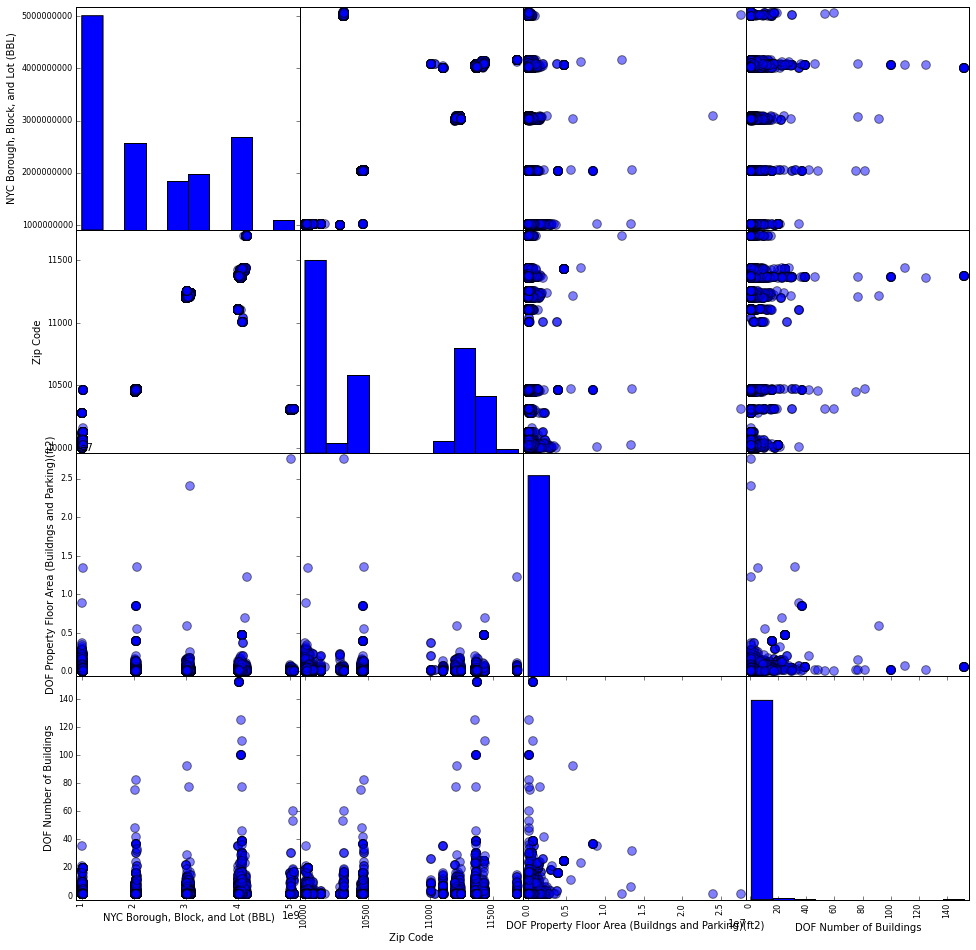

In [26]:
#plot the same thing with histograms on the diagonals for more information
scatter_matrix (nrg, s = 300, figsize = (16, 16), diagonal = 'hist')

In [27]:
#define a function to convert the columns we will be using to float 
#def canconvert(mydata):
    #try:
        #float(mydata)
        #return True
    #except ValueError:
        #return False

In [28]:
#create "true/false" boolean arrays using canconvert for the columns we 
#will be using - Site EUI and Property Floor Area

nrg['Reported Property Floor Area (Building(s)) (ft\xc2\xb2)'] = nrg['Reported Property Floor Area (Building(s)) (ft\xc2\xb2)'].convert_objects(convert_numeric = True)
nrg['Site EUI(kBtu/ft2)'] = nrg['Site EUI(kBtu/ft2)'].convert_objects(convert_numeric = True)



In [29]:
#check the BBLs as float in bsize and in nrg if there are no errors this is already 
# a float and we do not need to convert like we did for site EUI and floor
#area above
print bsize.BBL.astype(float)
print nrg['NYC Borough, Block, and Lot (BBL)'].astype(float)

0        1002760020
1        1002280022
2        1005900056
3        1005890030
4        1005310056
5        1011860040
6        1004940026
7        1005580017
8        1001807505
9        1005820050
10       1004680049
11       1008090073
12       1002040034
13       1002270019
14       1001367504
15       1006120028
16       1004230028
17       1004100032
18       1008980025
19       1008970053
20       1007870058
21       1003850030
22       1003870119
23       1009110055
24       1004070039
25       1004360002
26       1008850079
27       1007760001
28       1000190013
29       1006220070
            ...    
42756    1017090031
42757    1011710069
42758    1011090100
42759    1015320036
42760    1010517502
42761    1006990009
42762    1007460059
42763    1007760033
42764    1002460005
42765    1019120043
42766    1018520020
42767    1017270067
42768    1007050050
42769    1022150806
42770    1005310016
42771    1017800075
42772    1003010011
42773    1016527501
42774    1004930030


In [30]:
# create a new column in NRG called BBL which contains the values in 
#'NYC Borough, Block and Lot (BBL)' as floats 
nrg['BBL'] = nrg['NYC Borough, Block, and Lot (BBL)'].astype(float)

In [31]:
#merge the data sets around the BBL
bblnrgdata = pd.merge(nrg, bsize, how = 'inner', on = 'BBL')

#print bblnrgdata
print bblnrgdata.head()

   NYC Borough, Block, and Lot (BBL) Co-reported BBL Status BBLs Co-reported  \
0                         1005050001                    NaN       1005050001   
1                         1021420100                    NaN       1021420100   
2                         1021750080                    NaN       1021750080   
3                         1003360005                    NaN       1003360005   
4                         1008070028                    NaN     1-00807-0028   

  Reported NYC Building Identificaiton Numbers (BINs) Street Number  \
0                                            1007817            150   
1                                            1063495           4079   
2                                            1064235             60   
3                                            1088884             16   
4                                            1015181            119   

         Street Name  Borough_x  Zip Code DOF Benchmarking Submission Status  \
0      VARIC

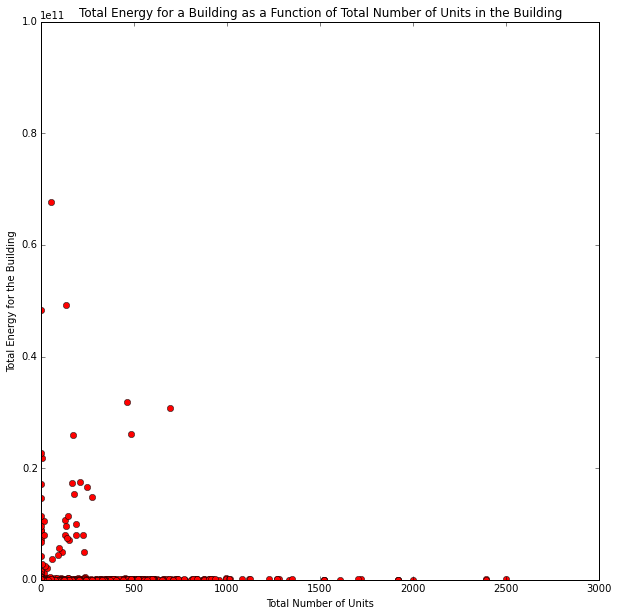

In [32]:
#plot Energy vs Number of Units (all units) in the building 
datax = bblnrgdata['UnitsTotal']
datay = (bblnrgdata['Site EUI(kBtu/ft2)']) * (bblnrgdata['Reported Property Floor Area (Building(s)) (ft\xc2\xb2)']
)
fig = figure(figsize = (10,10))
ax = fig.add_subplot(111)
ax.plot(datax, datay, 'ro')
ax.set_xlim(1, 3000)
ax.set_ylim(1000, 1e11)
plt.xlabel('Total Number of Units')
plt.ylabel('Total Energy for the Building')
plt.title('Total Energy for a Building as a Function of Total Number of Units in the Building')



In [33]:
#Cut the Data Set - Create an Index of booleans)
index = ((datax>0)&(datax<4000)) & ((datay>1000)&(datay<1e11))
#print index

In [34]:
#add a constant for OLS and take the log of data x if x is within our index
X = sm.add_constant(np.log10(datax[index]))
Y = np.log10(datay[index])
mod = sm.OLS(Y, X, missing = 'drop').fit()
print mod.summary()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     58.94
Date:                Tue, 13 Oct 2015   Prob (F-statistic):           1.94e-14
Time:                        19:52:22   Log-Likelihood:                -3848.6
No. Observations:                5002   AIC:                             7701.
Df Residuals:                    5000   BIC:                             7714.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          6.9178      0.019    359.148      0.0

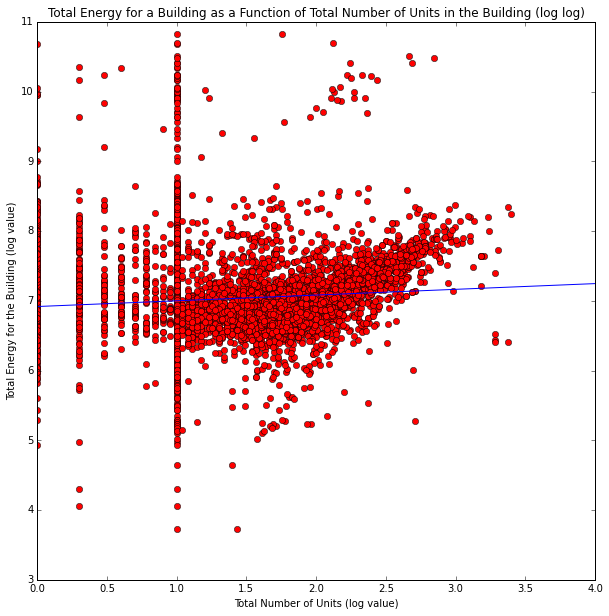

In [35]:
#plot Energy vs Number of Units (all units) in the building 

fig = figure(figsize = (10,10))
ax = fig.add_subplot(111)
ax.plot(X, Y, 'ro')
XLR = np.arange(0, 5, 1)
YLR = 0.0822*XLR + 6.9178
ax.plot(XLR, YLR, 'b')
plt.xlabel('Total Number of Units (log value)')
plt.ylabel('Total Energy for the Building (log value)')
plt.title('Total Energy for a Building as a Function of Total Number of Units in the Building (log log)')




In [36]:
#Flip Dependent and Independent Variables and get the linear regression
Y = sm.add_constant(np.log10(datay[index]))
X = np.log10(datax[index])
mod = sm.OLS(X, Y, missing = 'drop').fit()
print mod.summary()

                            OLS Regression Results                            
Dep. Variable:             UnitsTotal   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     58.94
Date:                Tue, 13 Oct 2015   Prob (F-statistic):           1.94e-14
Time:                        19:52:23   Log-Likelihood:                -5214.0
No. Observations:                5002   AIC:                         1.043e+04
Df Residuals:                    5000   BIC:                         1.045e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.6620      0.131      5.066      0.0

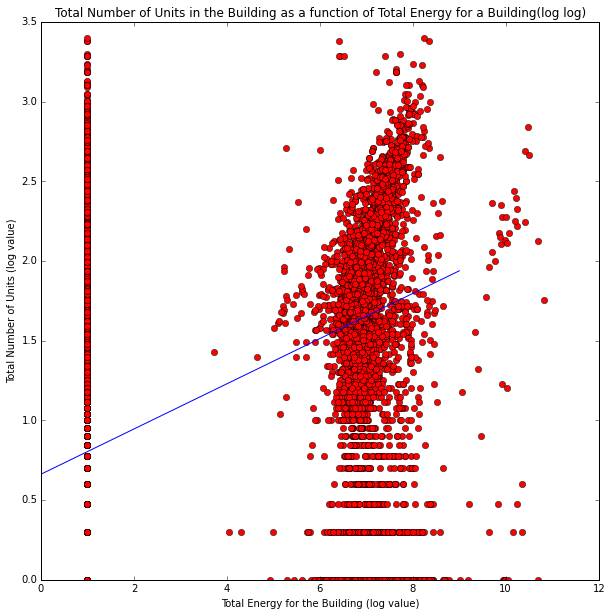

In [37]:
#plot Energy vs Number of Units (all units) in the building 

fig = figure(figsize = (10,10))
ax = fig.add_subplot(111)
ax.plot(Y, X, 'ro')
XLR = np.arange(0, 10, 1)
YLR = 0.1418*XLR + 0.6620
ax.plot(XLR, YLR, 'b')
plt.ylabel('Total Number of Units (log value)')
plt.xlabel('Total Energy for the Building (log value)')
plt.title('Total Number of Units in the Building as a function of Total Energy for a Building(log log)')

The linear regression where we have the Energy of the Building as the dependent variable is better.  The Energy of the Building is not evenly spaced over the x-axis which causes problems for OLS. 

#Second Degree Curve Fit

In [38]:
#Use np.polyfit for the second degree polynomial
XLOG = np.log10(datax[index])
YLOG = np.log10(datay[index])
mod = np.polyfit(XLOG, YLOG, 2)
print mod 

[ 0.32318823 -0.7819537   7.30719316]


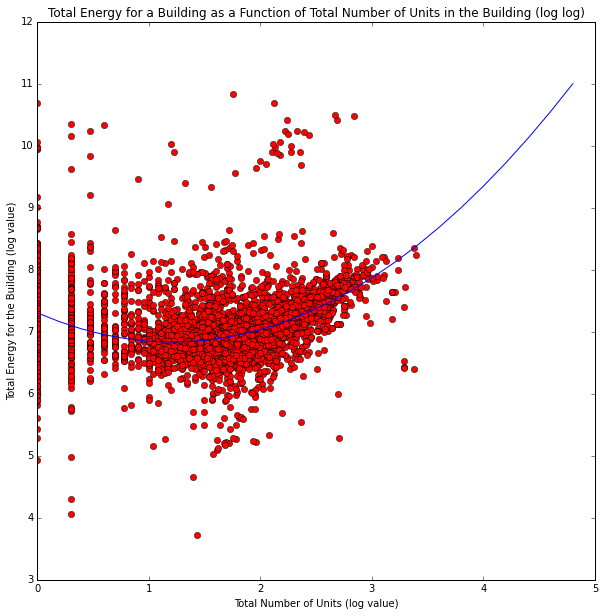

In [39]:
#plot Energy vs Number of Units (all units) in the building 

fig = figure(figsize = (10,10))
ax = fig.add_subplot(111)
ax.plot(XLOG, YLOG, 'ro')
XLR = np.arange(0, 5, .2)
YLR = 0.32318823*(XLR**2) - 0.7819537*XLR + 7.30719326
ax.plot(XLR, YLR, 'b')
plt.xlabel('Total Number of Units (log value)')
plt.ylabel('Total Energy for the Building (log value)')
plt.title('Total Energy for a Building as a Function of Total Number of Units in the Building (log log)')





The final model (log with a polynomial linear fit) appears to be the best fit.  A likelihood ratio could not be taken between these models because the difference in degrees of freedom between them is zero.  Looking at a chi squared table (log likeligood ratio) there is no row for zero degrees of freedom. 